# Larvae classification

## 1. Definitions

In [1]:
from pathlib import Path

import torch
from torch import nn
from torchsummary import summary
from torchvision import transforms

from dataset import ImageDataLoadBuilder, visualize_larvae_sample
from metrics import f1_fn, cohen_kappa_fn
from optim_utils import build_optimizer_and_scheduler
from models import EnhancedCNNClassifier
from training import Trainer

In [2]:
device = torch.device(0) if torch.cuda.is_available() else torch.device("cpu")

In [3]:
import gc

def clean_memory():
    gc.collect()
    torch.cuda.empty_cache()

clean_memory()

In [4]:
width = 224
height = 224
nchannels = 3
input_size = (height, width)
input_shape = (nchannels, height, width)
num_classes = 2
imagenet_mean, imagenet_std = (0.485, 0.456, 0.406), (0.229, 0.224, 0.225)
labels_map = {
    0: "Larvae",
    1: "Non-larvae",
}

## 2. Data ETL

In [5]:
# Regular preprocessing transformation
preparation = transforms.Compose(
    [
        transforms.Resize(
            input_size,
            interpolation=transforms.InterpolationMode.BILINEAR,
            max_size=None,
            antialias=True,
        ),
        transforms.ToTensor(),
        transforms.Normalize(imagenet_mean, imagenet_std),
    ]
)

# Data augmentation transformation
augmentation = transforms.Compose(
    [
        transforms.Resize(
            (300, 300),
            interpolation=transforms.InterpolationMode.BILINEAR,
            max_size=None,
            antialias=True,
        ),
        transforms.RandomAffine(
            degrees=10,
            translate=(0.05, 0.10),
            scale=(0.9, 1.1),
            shear=(-2, 2),
            interpolation=transforms.InterpolationMode.BILINEAR,
            fill=0,
        ),
        transforms.CenterCrop(250),
        preparation,
    ]
)

In [6]:
builder = ImageDataLoadBuilder(
    data_dir=Path("./images/larvae"),
    train_transform=augmentation,
    valid_transform=preparation,
    test_transform=preparation,
)
train_loader, valid_loader, test_loader = builder.get_tvt_splited_dataloaders()

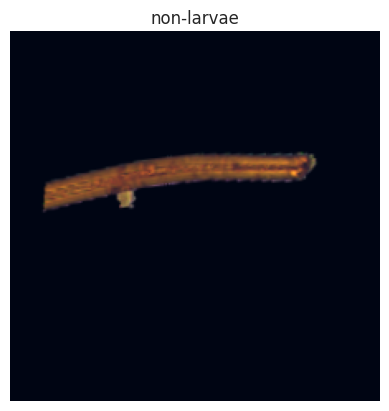

In [7]:
visualize_larvae_sample(train_loader.dataset)

In [8]:
len(train_loader.dataset), len(valid_loader.dataset), len(test_loader.dataset)

(798, 320, 480)

## 3. Training

### 3.1. Criterion

Since larvae data is unbalanced, we will use cross entropy with weights.

In [9]:
from torch import Tensor

N0 = 247
N1 = 1351
weights = Tensor([1.0, N0 / N1])
criterion = nn.CrossEntropyLoss(weight=weights)

optim_config = {
    "scheduler": "onecycle",
    "max_lr": 2e-4,
    "lr": 1e-4,
    "eta_min": 1e-6,
    "weight_decay": 1e-4,
    "warmup_epochs": 6,
}

# criterion = nn.CrossEntropyLoss()

### 3.2. CNN0

In [10]:
cnn_0 = EnhancedCNNClassifier(
    input_shape=input_shape,
    num_classes=num_classes,
    block_type="residual",
    device=device,
)
summary(cnn_0, input_shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 8, 224, 224]             224
       BatchNorm2d-2          [-1, 8, 224, 224]              16
              ReLU-3          [-1, 8, 224, 224]               0
            Conv2d-4          [-1, 8, 224, 224]             584
       BatchNorm2d-5          [-1, 8, 224, 224]              16
              ReLU-6          [-1, 8, 224, 224]               0
            Conv2d-7          [-1, 8, 224, 224]             584
       BatchNorm2d-8          [-1, 8, 224, 224]              16
              ReLU-9          [-1, 8, 224, 224]               0
    ResidualBlock-10          [-1, 8, 224, 224]               0
        MaxPool2d-11          [-1, 8, 112, 112]               0
           Conv2d-12         [-1, 16, 112, 112]           1,168
      BatchNorm2d-13         [-1, 16, 112, 112]              32
             ReLU-14         [-1, 16, 1

In [11]:
optimizer_cnn_0, scheduler_cnn_0 = build_optimizer_and_scheduler(
    cnn_0,
    optim_config,
    train_loader_len=len(train_loader),
    total_epochs=60,
)
ckpt_cnn_0 = "weights/larvae-adv-cnn-0.pt"
trainer_cnn_0 = Trainer(
    model=cnn_0,
    optimizer=optimizer_cnn_0,
    criterion=criterion,
    device=device,
    scheduler=scheduler_cnn_0,
    checkpoint_path=ckpt_cnn_0,
    patience=5,
    metric_fns=[cohen_kappa_fn, f1_fn],
)

In [12]:
trainer_cnn_0.fit(train_loader, valid_loader, num_epochs=60)

❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Not enough classes to compute F1 score. Returning 0.0.
❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Not enough classes to compute F1 score. Returning 0.0.
📘 Epoch 1 | Train Loss: 0.6932 | Val Loss: 0.6931 | Train cohen_kappa_fn: 0.0000 | Val cohen_kappa_fn: 0.0000 | Train f1_fn: 0.0000 | Val f1_fn: 0.0000
  🔥 New best model saved!


❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Not enough classes to compute F1 score. Returning 0.0.
❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Not enough classes to compute F1 score. Returning 0.0.
📘 Epoch 2 | Train Loss: 0.6931 | Val Loss: 0.6930 | Train cohen_kappa_fn: 0.0000 | Val cohen_kappa_fn: 0.0000 | Train f1_fn: 0.0000 | Val f1_fn: 0.0000
  🔥 New best model saved!


❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Not enough classes to compute F1 score. Returning 0.0.
❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Not enough classes to compute F1 score. Returning 0.0.
📘 Epoch 3 | Train Loss: 0.6928 | Val Loss: 0.6929 | Train cohen_kappa_fn: 0.0000 | Val cohen_kappa_fn: 0.0000 | Train f1_fn: 0.0000 | Val f1_fn: 0.0000
  🔥 New best model saved!


❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Not enough classes to compute F1 score. Returning 0.0.
❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Not enough classes to compute F1 score. Returning 0.0.
📘 Epoch 4 | Train Loss: 0.6925 | Val Loss: 0.6919 | Train cohen_kappa_fn: 0.0000 | Val cohen_kappa_fn: 0.0000 | Train f1_fn: 0.0000 | Val f1_fn: 0.0000
  🔥 New best model saved!


❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Not enough classes to compute F1 score. Returning 0.0.
❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Not enough classes to compute F1 score. Returning 0.0.
📘 Epoch 5 | Train Loss: 0.6898 | Val Loss: 0.6893 | Train cohen_kappa_fn: 0.0000 | Val cohen_kappa_fn: 0.0000 | Train f1_fn: 0.0000 | Val f1_fn: 0.0000
  🔥 New best model saved!


❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Not enough classes to compute F1 score. Returning 0.0.
❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Not enough classes to compute F1 score. Returning 0.0.
📘 Epoch 6 | Train Loss: 0.6830 | Val Loss: 0.6692 | Train cohen_kappa_fn: 0.0000 | Val cohen_kappa_fn: 0.0000 | Train f1_fn: 0.0000 | Val f1_fn: 0.0000
  🔥 New best model saved!


❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Not enough classes to compute F1 score. Returning 0.0.
❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Not enough classes to compute F1 score. Returning 0.0.
📘 Epoch 7 | Train Loss: 0.6557 | Val Loss: 0.6405 | Train cohen_kappa_fn: 0.0000 | Val cohen_kappa_fn: 0.0000 | Train f1_fn: 0.0000 | Val f1_fn: 0.0000
  🔥 New best model saved!


❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Not enough classes to compute F1 score. Returning 0.0.
❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Not enough classes to compute F1 score. Returning 0.0.
📘 Epoch 8 | Train Loss: 0.6127 | Val Loss: 0.6381 | Train cohen_kappa_fn: 0.0000 | Val cohen_kappa_fn: 0.0000 | Train f1_fn: 0.0000 | Val f1_fn: 0.0000
  🔥 New best model saved!


📘 Epoch 9 | Train Loss: 0.5808 | Val Loss: 0.5380 | Train cohen_kappa_fn: 0.4876 | Val cohen_kappa_fn: 0.5094 | Train f1_fn: 0.9398 | Val f1_fn: 0.9353
  🔥 New best model saved!


📘 Epoch 10 | Train Loss: 0.5355 | Val Loss: 0.4966 | Train cohen_kappa_fn: 0.6437 | Val cohen_kappa_fn: 0.5964 | Train f1_fn: 0.9514 | Val f1_fn: 0.9437
  🔥 New best model saved!


📘 Epoch 11 | Train Loss: 0.4839 | Val Loss: 0.5159 | Train cohen_kappa_fn: 0.6742 | Val cohen_kappa_fn: 0.5544 | Train f1_fn: 0.9575 | Val f1_fn: 0.9405
  ❄️ No improvement, model won't be saved!


📘 Epoch 12 | Train Loss: 0.4546 | Val Loss: 0.4455 | Train cohen_kappa_fn: 0.6275 | Val cohen_kappa_fn: 0.6610 | Train f1_fn: 0.9501 | Val f1_fn: 0.9438
  🔥 New best model saved!


📘 Epoch 13 | Train Loss: 0.3325 | Val Loss: 0.2773 | Train cohen_kappa_fn: 0.7879 | Val cohen_kappa_fn: 0.7024 | Train f1_fn: 0.9618 | Val f1_fn: 0.9443
  🔥 New best model saved!


📘 Epoch 14 | Train Loss: 0.2719 | Val Loss: 0.3887 | Train cohen_kappa_fn: 0.7562 | Val cohen_kappa_fn: 0.7305 | Train f1_fn: 0.9666 | Val f1_fn: 0.9596
  ❄️ No improvement, model won't be saved!


📘 Epoch 15 | Train Loss: 0.2190 | Val Loss: 0.3030 | Train cohen_kappa_fn: 0.4960 | Val cohen_kappa_fn: 0.4426 | Train f1_fn: 0.8646 | Val f1_fn: 0.8394
  ❄️ No improvement, model won't be saved!


📘 Epoch 16 | Train Loss: 0.1700 | Val Loss: 0.3363 | Train cohen_kappa_fn: 0.8759 | Val cohen_kappa_fn: 0.7491 | Train f1_fn: 0.9807 | Val f1_fn: 0.9612
  ❄️ No improvement, model won't be saved!


📘 Epoch 17 | Train Loss: 0.1763 | Val Loss: 0.2115 | Train cohen_kappa_fn: 0.6654 | Val cohen_kappa_fn: 0.6688 | Train f1_fn: 0.9287 | Val f1_fn: 0.9312
  🔥 New best model saved!


📘 Epoch 18 | Train Loss: 0.1497 | Val Loss: 0.2545 | Train cohen_kappa_fn: 0.8841 | Val cohen_kappa_fn: 0.7704 | Train f1_fn: 0.9813 | Val f1_fn: 0.9627
  ❄️ No improvement, model won't be saved!


📘 Epoch 19 | Train Loss: 0.1649 | Val Loss: 0.2849 | Train cohen_kappa_fn: 0.9009 | Val cohen_kappa_fn: 0.7339 | Train f1_fn: 0.9835 | Val f1_fn: 0.9572
  ❄️ No improvement, model won't be saved!


📘 Epoch 20 | Train Loss: 0.1542 | Val Loss: 0.2578 | Train cohen_kappa_fn: 0.8689 | Val cohen_kappa_fn: 0.7704 | Train f1_fn: 0.9782 | Val f1_fn: 0.9627
  ❄️ No improvement, model won't be saved!


📘 Epoch 21 | Train Loss: 0.1204 | Val Loss: 0.2670 | Train cohen_kappa_fn: 0.8558 | Val cohen_kappa_fn: 0.8064 | Train f1_fn: 0.9759 | Val f1_fn: 0.9682
  ❄️ No improvement, model won't be saved!


📘 Epoch 22 | Train Loss: 0.1182 | Val Loss: 0.2558 | Train cohen_kappa_fn: 0.8738 | Val cohen_kappa_fn: 0.8164 | Train f1_fn: 0.9789 | Val f1_fn: 0.9701
  ❄️ No improvement, model won't be saved!
⏹️ Early stopping triggered.


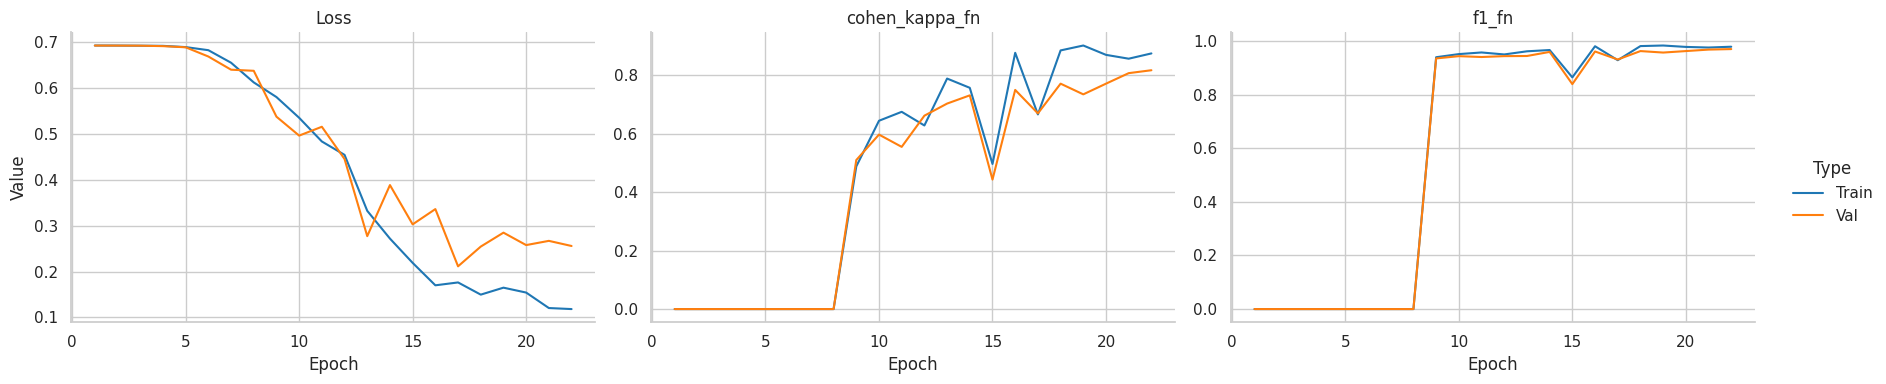

In [13]:
trainer_cnn_0.plot_epochs()

In [14]:
trainer_cnn_0.test(test_loader)

📦 Loading best model...
✅ Done!
Test Loss: 0.2011 | Test cohen_kappa_fn: 0.7485 | Test f1_fn: 0.9542


### 3.3. CNN1

In [15]:
cnn_1 = EnhancedCNNClassifier(
    input_shape=input_shape,
    num_classes=num_classes,
    block_type="inception",
    device=device,
)
summary(cnn_1, input_shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 2, 224, 224]               8
            Conv2d-2          [-1, 2, 224, 224]               8
            Conv2d-3          [-1, 2, 224, 224]              38
            Conv2d-4          [-1, 2, 224, 224]               8
            Conv2d-5          [-1, 2, 224, 224]             102
         MaxPool2d-6          [-1, 3, 224, 224]               0
            Conv2d-7          [-1, 2, 224, 224]               8
       BatchNorm2d-8          [-1, 8, 224, 224]              16
    InceptionBlock-9          [-1, 8, 224, 224]               0
        MaxPool2d-10          [-1, 8, 112, 112]               0
           Conv2d-11          [-1, 4, 112, 112]              36
           Conv2d-12          [-1, 4, 112, 112]              36
           Conv2d-13          [-1, 4, 112, 112]             148
           Conv2d-14          [-1, 4, 1

In [16]:
optimizer_cnn_1, scheduler_cnn_1 = build_optimizer_and_scheduler(
    cnn_1,
    optim_config,
    train_loader_len=len(train_loader),
    total_epochs=60,
)
ckpt_cnn_1 = "weights/larvae-adv-cnn-1.pt"
trainer_cnn_1 = Trainer(
    model=cnn_1,
    optimizer=optimizer_cnn_1,
    criterion=criterion,
    device=device,
    scheduler=scheduler_cnn_1,
    checkpoint_path=ckpt_cnn_1,
    patience=5,
    metric_fns=[cohen_kappa_fn, f1_fn],
)

In [17]:
trainer_cnn_1.fit(train_loader, valid_loader, num_epochs=60)

📘 Epoch 1 | Train Loss: 0.6925 | Val Loss: 0.6915 | Train cohen_kappa_fn: 0.1756 | Val cohen_kappa_fn: 0.1450 | Train f1_fn: 0.6174 | Val f1_fn: 0.5205
  🔥 New best model saved!


📘 Epoch 2 | Train Loss: 0.6898 | Val Loss: 0.6870 | Train cohen_kappa_fn: 0.3178 | Val cohen_kappa_fn: 0.2686 | Train f1_fn: 0.7873 | Val f1_fn: 0.7385
  🔥 New best model saved!


📘 Epoch 3 | Train Loss: 0.6806 | Val Loss: 0.6753 | Train cohen_kappa_fn: 0.3056 | Val cohen_kappa_fn: 0.2597 | Train f1_fn: 0.7736 | Val f1_fn: 0.7153
  🔥 New best model saved!


📘 Epoch 4 | Train Loss: 0.6612 | Val Loss: 0.6484 | Train cohen_kappa_fn: 0.3640 | Val cohen_kappa_fn: 0.3075 | Train f1_fn: 0.8362 | Val f1_fn: 0.7887
  🔥 New best model saved!


📘 Epoch 5 | Train Loss: 0.6304 | Val Loss: 0.6047 | Train cohen_kappa_fn: 0.3506 | Val cohen_kappa_fn: 0.2750 | Train f1_fn: 0.8154 | Val f1_fn: 0.7373
  🔥 New best model saved!


📘 Epoch 6 | Train Loss: 0.5845 | Val Loss: 0.5522 | Train cohen_kappa_fn: 0.4141 | Val cohen_kappa_fn: 0.3875 | Train f1_fn: 0.8564 | Val f1_fn: 0.8248
  🔥 New best model saved!


📘 Epoch 7 | Train Loss: 0.5342 | Val Loss: 0.4953 | Train cohen_kappa_fn: 0.4652 | Val cohen_kappa_fn: 0.5545 | Train f1_fn: 0.8698 | Val f1_fn: 0.9051
  🔥 New best model saved!


📘 Epoch 8 | Train Loss: 0.4831 | Val Loss: 0.4350 | Train cohen_kappa_fn: 0.5215 | Val cohen_kappa_fn: 0.5908 | Train f1_fn: 0.8935 | Val f1_fn: 0.9207
  🔥 New best model saved!


📘 Epoch 9 | Train Loss: 0.4276 | Val Loss: 0.3916 | Train cohen_kappa_fn: 0.5466 | Val cohen_kappa_fn: 0.6892 | Train f1_fn: 0.9043 | Val f1_fn: 0.9450
  🔥 New best model saved!


📘 Epoch 10 | Train Loss: 0.4124 | Val Loss: 0.3646 | Train cohen_kappa_fn: 0.6095 | Val cohen_kappa_fn: 0.7245 | Train f1_fn: 0.9239 | Val f1_fn: 0.9552
  🔥 New best model saved!


📘 Epoch 11 | Train Loss: 0.3874 | Val Loss: 0.3459 | Train cohen_kappa_fn: 0.5349 | Val cohen_kappa_fn: 0.5475 | Train f1_fn: 0.8882 | Val f1_fn: 0.9004
  🔥 New best model saved!


📘 Epoch 12 | Train Loss: 0.3609 | Val Loss: 0.3389 | Train cohen_kappa_fn: 0.7423 | Val cohen_kappa_fn: 0.7692 | Train f1_fn: 0.9572 | Val f1_fn: 0.9650
  🔥 New best model saved!


📘 Epoch 13 | Train Loss: 0.3607 | Val Loss: 0.3157 | Train cohen_kappa_fn: 0.5744 | Val cohen_kappa_fn: 0.5610 | Train f1_fn: 0.9056 | Val f1_fn: 0.9073
  🔥 New best model saved!


📘 Epoch 14 | Train Loss: 0.3647 | Val Loss: 0.3199 | Train cohen_kappa_fn: 0.7012 | Val cohen_kappa_fn: 0.7491 | Train f1_fn: 0.9476 | Val f1_fn: 0.9612
  ❄️ No improvement, model won't be saved!


📘 Epoch 15 | Train Loss: 0.3326 | Val Loss: 0.3304 | Train cohen_kappa_fn: 0.7428 | Val cohen_kappa_fn: 0.7795 | Train f1_fn: 0.9581 | Val f1_fn: 0.9669
  ❄️ No improvement, model won't be saved!


📘 Epoch 16 | Train Loss: 0.2767 | Val Loss: 0.2903 | Train cohen_kappa_fn: 0.6243 | Val cohen_kappa_fn: 0.6017 | Train f1_fn: 0.9210 | Val f1_fn: 0.9201
  🔥 New best model saved!


📘 Epoch 17 | Train Loss: 0.3285 | Val Loss: 0.3302 | Train cohen_kappa_fn: 0.7653 | Val cohen_kappa_fn: 0.7508 | Train f1_fn: 0.9637 | Val f1_fn: 0.9634
  ❄️ No improvement, model won't be saved!


📘 Epoch 18 | Train Loss: 0.3110 | Val Loss: 0.2948 | Train cohen_kappa_fn: 0.6434 | Val cohen_kappa_fn: 0.6645 | Train f1_fn: 0.9300 | Val f1_fn: 0.9389
  ❄️ No improvement, model won't be saved!


📘 Epoch 19 | Train Loss: 0.2787 | Val Loss: 0.3401 | Train cohen_kappa_fn: 0.7589 | Val cohen_kappa_fn: 0.7550 | Train f1_fn: 0.9621 | Val f1_fn: 0.9632
  ❄️ No improvement, model won't be saved!


📘 Epoch 20 | Train Loss: 0.2804 | Val Loss: 0.2619 | Train cohen_kappa_fn: 0.6606 | Val cohen_kappa_fn: 0.6565 | Train f1_fn: 0.9310 | Val f1_fn: 0.9369
  🔥 New best model saved!


📘 Epoch 21 | Train Loss: 0.2922 | Val Loss: 0.3053 | Train cohen_kappa_fn: 0.7953 | Val cohen_kappa_fn: 0.7449 | Train f1_fn: 0.9662 | Val f1_fn: 0.9613
  ❄️ No improvement, model won't be saved!


📘 Epoch 22 | Train Loss: 0.2980 | Val Loss: 0.2833 | Train cohen_kappa_fn: 0.7269 | Val cohen_kappa_fn: 0.7339 | Train f1_fn: 0.9512 | Val f1_fn: 0.9572
  ❄️ No improvement, model won't be saved!


📘 Epoch 23 | Train Loss: 0.2639 | Val Loss: 0.3267 | Train cohen_kappa_fn: 0.7288 | Val cohen_kappa_fn: 0.7349 | Train f1_fn: 0.9521 | Val f1_fn: 0.9594
  ❄️ No improvement, model won't be saved!


📘 Epoch 24 | Train Loss: 0.2763 | Val Loss: 0.4193 | Train cohen_kappa_fn: 0.7614 | Val cohen_kappa_fn: 0.6729 | Train f1_fn: 0.9647 | Val f1_fn: 0.9568
  ❄️ No improvement, model won't be saved!


📘 Epoch 25 | Train Loss: 0.2613 | Val Loss: 0.2610 | Train cohen_kappa_fn: 0.5975 | Val cohen_kappa_fn: 0.5947 | Train f1_fn: 0.9092 | Val f1_fn: 0.9180
  🔥 New best model saved!


📘 Epoch 26 | Train Loss: 0.2676 | Val Loss: 0.2910 | Train cohen_kappa_fn: 0.7450 | Val cohen_kappa_fn: 0.7349 | Train f1_fn: 0.9561 | Val f1_fn: 0.9594
  ❄️ No improvement, model won't be saved!


📘 Epoch 27 | Train Loss: 0.2341 | Val Loss: 0.2832 | Train cohen_kappa_fn: 0.7455 | Val cohen_kappa_fn: 0.7339 | Train f1_fn: 0.9542 | Val f1_fn: 0.9572
  ❄️ No improvement, model won't be saved!


📘 Epoch 28 | Train Loss: 0.2534 | Val Loss: 0.2674 | Train cohen_kappa_fn: 0.7293 | Val cohen_kappa_fn: 0.7107 | Train f1_fn: 0.9482 | Val f1_fn: 0.9511
  ❄️ No improvement, model won't be saved!


📘 Epoch 29 | Train Loss: 0.2314 | Val Loss: 0.3261 | Train cohen_kappa_fn: 0.7900 | Val cohen_kappa_fn: 0.7718 | Train f1_fn: 0.9664 | Val f1_fn: 0.9672
  ❄️ No improvement, model won't be saved!


📘 Epoch 30 | Train Loss: 0.2328 | Val Loss: 0.2562 | Train cohen_kappa_fn: 0.7115 | Val cohen_kappa_fn: 0.7514 | Train f1_fn: 0.9452 | Val f1_fn: 0.9588
  🔥 New best model saved!


📘 Epoch 31 | Train Loss: 0.2065 | Val Loss: 0.3552 | Train cohen_kappa_fn: 0.7536 | Val cohen_kappa_fn: 0.7570 | Train f1_fn: 0.9595 | Val f1_fn: 0.9654
  ❄️ No improvement, model won't be saved!


📘 Epoch 32 | Train Loss: 0.2592 | Val Loss: 0.2654 | Train cohen_kappa_fn: 0.7348 | Val cohen_kappa_fn: 0.7475 | Train f1_fn: 0.9508 | Val f1_fn: 0.9590
  ❄️ No improvement, model won't be saved!


📘 Epoch 33 | Train Loss: 0.2332 | Val Loss: 0.2638 | Train cohen_kappa_fn: 0.7226 | Val cohen_kappa_fn: 0.7475 | Train f1_fn: 0.9456 | Val f1_fn: 0.9590
  ❄️ No improvement, model won't be saved!


📘 Epoch 34 | Train Loss: 0.2184 | Val Loss: 0.3461 | Train cohen_kappa_fn: 0.8255 | Val cohen_kappa_fn: 0.7570 | Train f1_fn: 0.9716 | Val f1_fn: 0.9654
  ❄️ No improvement, model won't be saved!


📘 Epoch 35 | Train Loss: 0.2212 | Val Loss: 0.3204 | Train cohen_kappa_fn: 0.7470 | Val cohen_kappa_fn: 0.7612 | Train f1_fn: 0.9541 | Val f1_fn: 0.9653
  ❄️ No improvement, model won't be saved!
⏹️ Early stopping triggered.


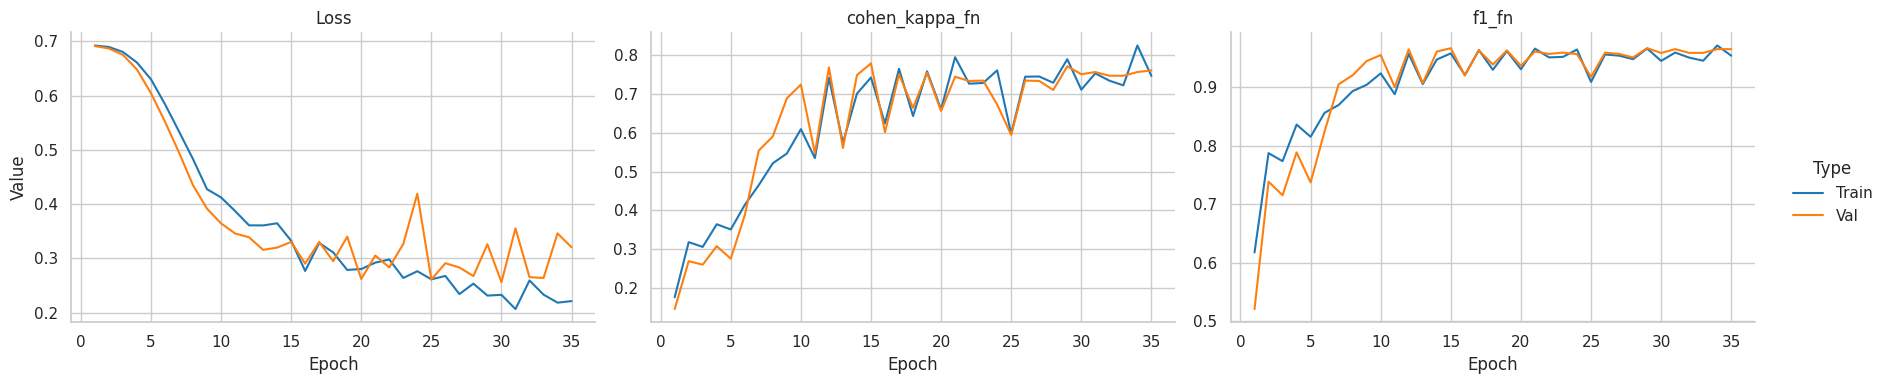

In [18]:
trainer_cnn_1.plot_epochs()

In [19]:
trainer_cnn_1.test(test_loader)

📦 Loading best model...
✅ Done!
Test Loss: 0.2532 | Test cohen_kappa_fn: 0.7093 | Test f1_fn: 0.9527


### 3.4. CNN2

In [20]:
cnn_2 = EnhancedCNNClassifier(
    input_shape=input_shape,
    num_classes=num_classes,
    block_type="se",
    device=device,
)
summary(cnn_2, input_shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 8, 224, 224]             224
              ReLU-2          [-1, 8, 224, 224]               0
 AdaptiveAvgPool2d-3              [-1, 8, 1, 1]               0
            Linear-4                    [-1, 0]               0
              ReLU-5                    [-1, 0]               0
            Linear-6                    [-1, 8]               8
           Sigmoid-7                    [-1, 8]               0
           SEBlock-8          [-1, 8, 224, 224]               0
         MaxPool2d-9          [-1, 8, 112, 112]               0
           Conv2d-10         [-1, 16, 112, 112]           1,168
             ReLU-11         [-1, 16, 112, 112]               0
AdaptiveAvgPool2d-12             [-1, 16, 1, 1]               0
           Linear-13                    [-1, 1]              17
             ReLU-14                   

/home/gio/personal/masters/.venv/lib/python3.12/site-packages/torch/nn/init.py:511: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


In [21]:
optimizer_cnn_2, scheduler_cnn_2 = build_optimizer_and_scheduler(
    cnn_2,
    optim_config,
    train_loader_len=len(train_loader),
    total_epochs=60,
)
ckpt_cnn_2 = "weights/larvae-adv-cnn-2.pt"
trainer_cnn_2 = Trainer(
    model=cnn_2,
    optimizer=optimizer_cnn_2,
    criterion=criterion,
    device=device,
    scheduler=scheduler_cnn_2,
    checkpoint_path=ckpt_cnn_2,
    patience=5,
    metric_fns=[cohen_kappa_fn, f1_fn],
)

In [22]:
trainer_cnn_2.fit(train_loader, valid_loader, num_epochs=60)

❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Not enough classes to compute F1 score. Returning 0.0.
❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Not enough classes to compute F1 score. Returning 0.0.
📘 Epoch 1 | Train Loss: 0.6931 | Val Loss: 0.6931 | Train cohen_kappa_fn: 0.0000 | Val cohen_kappa_fn: 0.0000 | Train f1_fn: 0.0000 | Val f1_fn: 0.0000
  🔥 New best model saved!


❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Not enough classes to compute F1 score. Returning 0.0.
❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Not enough classes to compute F1 score. Returning 0.0.
📘 Epoch 2 | Train Loss: 0.6930 | Val Loss: 0.6930 | Train cohen_kappa_fn: 0.0000 | Val cohen_kappa_fn: 0.0000 | Train f1_fn: 0.0000 | Val f1_fn: 0.0000
  🔥 New best model saved!


❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Not enough classes to compute F1 score. Returning 0.0.
❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Not enough classes to compute F1 score. Returning 0.0.
📘 Epoch 3 | Train Loss: 0.6929 | Val Loss: 0.6931 | Train cohen_kappa_fn: 0.0000 | Val cohen_kappa_fn: 0.0000 | Train f1_fn: 0.0000 | Val f1_fn: 0.0000
  ❄️ No improvement, model won't be saved!


❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Not enough classes to compute F1 score. Returning 0.0.
❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Not enough classes to compute F1 score. Returning 0.0.
📘 Epoch 4 | Train Loss: 0.6930 | Val Loss: 0.6927 | Train cohen_kappa_fn: 0.0000 | Val cohen_kappa_fn: 0.0000 | Train f1_fn: 0.0000 | Val f1_fn: 0.0000
  🔥 New best model saved!


❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Not enough classes to compute F1 score. Returning 0.0.
❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Not enough classes to compute F1 score. Returning 0.0.
📘 Epoch 5 | Train Loss: 0.6929 | Val Loss: 0.6926 | Train cohen_kappa_fn: 0.0000 | Val cohen_kappa_fn: 0.0000 | Train f1_fn: 0.0000 | Val f1_fn: 0.0000
  🔥 New best model saved!


❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Not enough classes to compute F1 score. Returning 0.0.
❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Not enough classes to compute F1 score. Returning 0.0.
📘 Epoch 6 | Train Loss: 0.6927 | Val Loss: 0.6928 | Train cohen_kappa_fn: 0.0000 | Val cohen_kappa_fn: 0.0000 | Train f1_fn: 0.0000 | Val f1_fn: 0.0000
  ❄️ No improvement, model won't be saved!


❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Not enough classes to compute F1 score. Returning 0.0.
❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Not enough classes to compute F1 score. Returning 0.0.
📘 Epoch 7 | Train Loss: 0.6924 | Val Loss: 0.6927 | Train cohen_kappa_fn: 0.0000 | Val cohen_kappa_fn: 0.0000 | Train f1_fn: 0.0000 | Val f1_fn: 0.0000
  ❄️ No improvement, model won't be saved!


❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Not enough classes to compute F1 score. Returning 0.0.
❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Not enough classes to compute F1 score. Returning 0.0.
📘 Epoch 8 | Train Loss: 0.6921 | Val Loss: 0.6925 | Train cohen_kappa_fn: 0.0000 | Val cohen_kappa_fn: 0.0000 | Train f1_fn: 0.0000 | Val f1_fn: 0.0000
  🔥 New best model saved!


❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Not enough classes to compute F1 score. Returning 0.0.
❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Not enough classes to compute F1 score. Returning 0.0.
📘 Epoch 9 | Train Loss: 0.6923 | Val Loss: 0.6929 | Train cohen_kappa_fn: 0.0000 | Val cohen_kappa_fn: 0.0000 | Train f1_fn: 0.0000 | Val f1_fn: 0.0000
  ❄️ No improvement, model won't be saved!


❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Not enough classes to compute F1 score. Returning 0.0.
❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Not enough classes to compute F1 score. Returning 0.0.
📘 Epoch 10 | Train Loss: 0.6925 | Val Loss: 0.6926 | Train cohen_kappa_fn: 0.0000 | Val cohen_kappa_fn: 0.0000 | Train f1_fn: 0.0000 | Val f1_fn: 0.0000
  ❄️ No improvement, model won't be saved!


❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Not enough classes to compute F1 score. Returning 0.0.
❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Not enough classes to compute F1 score. Returning 0.0.
📘 Epoch 11 | Train Loss: 0.6931 | Val Loss: 0.6922 | Train cohen_kappa_fn: 0.0000 | Val cohen_kappa_fn: 0.0000 | Train f1_fn: 0.0000 | Val f1_fn: 0.0000
  🔥 New best model saved!


❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Not enough classes to compute F1 score. Returning 0.0.
❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Not enough classes to compute F1 score. Returning 0.0.
📘 Epoch 12 | Train Loss: 0.6917 | Val Loss: 0.6921 | Train cohen_kappa_fn: 0.0000 | Val cohen_kappa_fn: 0.0000 | Train f1_fn: 0.0000 | Val f1_fn: 0.0000
  🔥 New best model saved!


❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Not enough classes to compute F1 score. Returning 0.0.
❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Not enough classes to compute F1 score. Returning 0.0.
📘 Epoch 13 | Train Loss: 0.6905 | Val Loss: 0.6912 | Train cohen_kappa_fn: 0.0000 | Val cohen_kappa_fn: 0.0000 | Train f1_fn: 0.0000 | Val f1_fn: 0.0000
  🔥 New best model saved!


❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Not enough classes to compute F1 score. Returning 0.0.
❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Not enough classes to compute F1 score. Returning 0.0.
📘 Epoch 14 | Train Loss: 0.6887 | Val Loss: 0.6881 | Train cohen_kappa_fn: 0.0000 | Val cohen_kappa_fn: 0.0000 | Train f1_fn: 0.0000 | Val f1_fn: 0.0000
  🔥 New best model saved!


❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Not enough classes to compute F1 score. Returning 0.0.
❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Not enough classes to compute F1 score. Returning 0.0.
📘 Epoch 15 | Train Loss: 0.6853 | Val Loss: 0.6849 | Train cohen_kappa_fn: 0.0000 | Val cohen_kappa_fn: 0.0000 | Train f1_fn: 0.0000 | Val f1_fn: 0.0000
  🔥 New best model saved!


❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Not enough classes to compute F1 score. Returning 0.0.
❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Not enough classes to compute F1 score. Returning 0.0.
📘 Epoch 16 | Train Loss: 0.6787 | Val Loss: 0.6739 | Train cohen_kappa_fn: 0.0000 | Val cohen_kappa_fn: 0.0000 | Train f1_fn: 0.0000 | Val f1_fn: 0.0000
  🔥 New best model saved!


❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Not enough classes to compute F1 score. Returning 0.0.
❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Not enough classes to compute F1 score. Returning 0.0.
📘 Epoch 17 | Train Loss: 0.6640 | Val Loss: 0.6657 | Train cohen_kappa_fn: 0.0000 | Val cohen_kappa_fn: 0.0000 | Train f1_fn: 0.0000 | Val f1_fn: 0.0000
  🔥 New best model saved!


❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Not enough classes to compute F1 score. Returning 0.0.
❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Not enough classes to compute F1 score. Returning 0.0.
📘 Epoch 18 | Train Loss: 0.6513 | Val Loss: 0.6507 | Train cohen_kappa_fn: 0.0000 | Val cohen_kappa_fn: 0.0000 | Train f1_fn: 0.0000 | Val f1_fn: 0.0000
  🔥 New best model saved!


❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Not enough classes to compute F1 score. Returning 0.0.
❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Not enough classes to compute F1 score. Returning 0.0.
📘 Epoch 19 | Train Loss: 0.6429 | Val Loss: 0.6383 | Train cohen_kappa_fn: 0.0000 | Val cohen_kappa_fn: 0.0000 | Train f1_fn: 0.0000 | Val f1_fn: 0.0000
  🔥 New best model saved!


❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Not enough classes to compute F1 score. Returning 0.0.
❗ Only one unique class in y_pred. Kappa score set to 0.0.
❗ Not enough classes to compute F1 score. Returning 0.0.
📘 Epoch 20 | Train Loss: 0.6296 | Val Loss: 0.6226 | Train cohen_kappa_fn: 0.0000 | Val cohen_kappa_fn: 0.0000 | Train f1_fn: 0.0000 | Val f1_fn: 0.0000
  🔥 New best model saved!


📘 Epoch 21 | Train Loss: 0.6099 | Val Loss: 0.6295 | Train cohen_kappa_fn: 0.1529 | Val cohen_kappa_fn: 0.1510 | Train f1_fn: 0.7528 | Val f1_fn: 0.7500
  ❄️ No improvement, model won't be saved!


KeyboardInterrupt: 

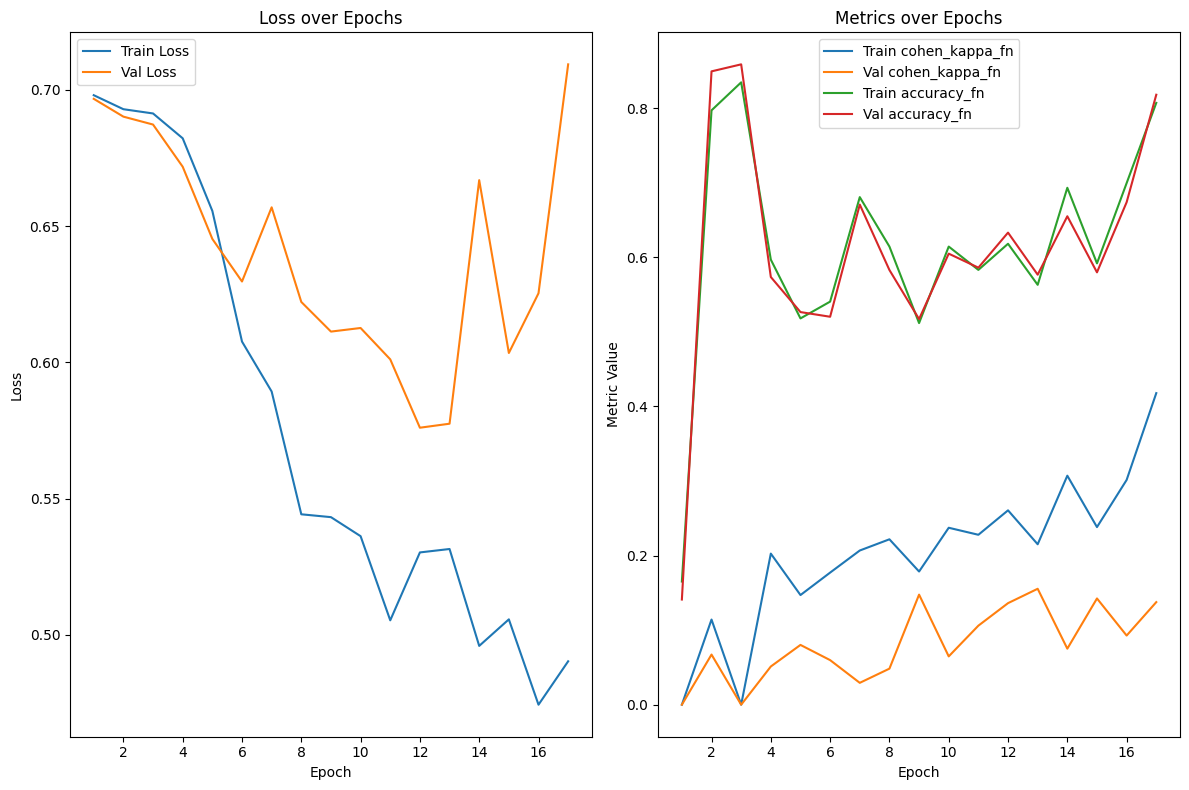

In [ ]:
trainer_cnn_2.plot_epochs()

In [ ]:
trainer_cnn_2.test(test_loader)

Test Loss: 0.6824 | Test cohen_kappa_fn: 0.0269 | Test accuracy_fn: 0.8021


### 3.5. CNN3

In [ ]:
cnn_3 = EnhancedCNNClassifier(
    input_shape=input_shape,
    num_classes=num_classes,
    block_type="cbam",
    device=device,
)
summary(cnn_3, input_shape)

/home/gio/personal/masters/.venv/lib/python3.12/site-packages/torch/nn/init.py:511: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


RuntimeError: Given groups=1, expected weight to be at least 1 at dimension 0, but got weight of size [0, 8, 1, 1] instead

In [ ]:
optimizer_cnn_3, scheduler_cnn_3 = build_optimizer_and_scheduler(
    cnn_3,
    optim_config,
    train_loader_len=len(train_loader),
    total_epochs=60,
)
ckpt_cnn_3 = "weights/larvae-adv-cnn-3.pt"
trainer_cnn_3 = Trainer(
    model=cnn_3,
    optimizer=optimizer_cnn_3,
    criterion=criterion,
    device=device,
    scheduler=scheduler_cnn_3,
    checkpoint_path=ckpt_cnn_3,
    patience=5,
    metric_fns=[cohen_kappa_fn, f1_fn],
)

In [ ]:
trainer_cnn_3.fit(train_loader, valid_loader, num_epochs=60)

❗ Only one unique class in y_pred. Kappa score set to 0.0.
📘 Epoch 1 | Train Loss: 0.7457 | Val Loss: 0.6797 | Train cohen_kappa_fn: 0.1935 | Val cohen_kappa_fn: 0.0000 | Train accuracy_fn: 0.8611 | Val accuracy_fn: 0.8558
  🔥 New best model saved!


📘 Epoch 2 | Train Loss: 0.6319 | Val Loss: 0.6155 | Train cohen_kappa_fn: 0.2091 | Val cohen_kappa_fn: 0.1002 | Train accuracy_fn: 0.5920 | Val accuracy_fn: 0.5611
  🔥 New best model saved!


📘 Epoch 3 | Train Loss: 0.5418 | Val Loss: 0.6516 | Train cohen_kappa_fn: 0.3802 | Val cohen_kappa_fn: 0.0892 | Train accuracy_fn: 0.7822 | Val accuracy_fn: 0.6614
  ❄️ Performance droped, model won't be saved!


📘 Epoch 4 | Train Loss: 0.4859 | Val Loss: 0.5681 | Train cohen_kappa_fn: 0.1990 | Val cohen_kappa_fn: 0.1523 | Train accuracy_fn: 0.5532 | Val accuracy_fn: 0.5204
  🔥 New best model saved!


📘 Epoch 5 | Train Loss: 0.5238 | Val Loss: 0.5800 | Train cohen_kappa_fn: 0.3684 | Val cohen_kappa_fn: 0.2123 | Train accuracy_fn: 0.7597 | Val accuracy_fn: 0.7335
  ❄️ Performance droped, model won't be saved!


📘 Epoch 6 | Train Loss: 0.4796 | Val Loss: 0.5544 | Train cohen_kappa_fn: 0.4481 | Val cohen_kappa_fn: 0.2951 | Train accuracy_fn: 0.8160 | Val accuracy_fn: 0.8276
  🔥 New best model saved!


📘 Epoch 7 | Train Loss: 0.4741 | Val Loss: 0.5246 | Train cohen_kappa_fn: 0.2600 | Val cohen_kappa_fn: 0.2043 | Train accuracy_fn: 0.6195 | Val accuracy_fn: 0.5799
  🔥 New best model saved!


📘 Epoch 8 | Train Loss: 0.4689 | Val Loss: 0.4900 | Train cohen_kappa_fn: 0.2111 | Val cohen_kappa_fn: 0.2063 | Train accuracy_fn: 0.5532 | Val accuracy_fn: 0.5580
  🔥 New best model saved!


📘 Epoch 9 | Train Loss: 0.4231 | Val Loss: 0.4851 | Train cohen_kappa_fn: 0.2498 | Val cohen_kappa_fn: 0.2265 | Train accuracy_fn: 0.5982 | Val accuracy_fn: 0.5831
  🔥 New best model saved!


📘 Epoch 10 | Train Loss: 0.4319 | Val Loss: 0.4875 | Train cohen_kappa_fn: 0.4476 | Val cohen_kappa_fn: 0.3713 | Train accuracy_fn: 0.7960 | Val accuracy_fn: 0.7649
  ❄️ Performance droped, model won't be saved!


📘 Epoch 11 | Train Loss: 0.3804 | Val Loss: 0.4292 | Train cohen_kappa_fn: 0.3950 | Val cohen_kappa_fn: 0.3649 | Train accuracy_fn: 0.7522 | Val accuracy_fn: 0.7398
  🔥 New best model saved!


📘 Epoch 12 | Train Loss: 0.3701 | Val Loss: 0.4619 | Train cohen_kappa_fn: 0.3789 | Val cohen_kappa_fn: 0.2642 | Train accuracy_fn: 0.7259 | Val accuracy_fn: 0.6395
  ❄️ Performance droped, model won't be saved!


📘 Epoch 13 | Train Loss: 0.3877 | Val Loss: 0.3675 | Train cohen_kappa_fn: 0.5086 | Val cohen_kappa_fn: 0.4919 | Train accuracy_fn: 0.8210 | Val accuracy_fn: 0.8213
  🔥 New best model saved!


📘 Epoch 14 | Train Loss: 0.3624 | Val Loss: 0.3544 | Train cohen_kappa_fn: 0.5753 | Val cohen_kappa_fn: 0.5681 | Train accuracy_fn: 0.8573 | Val accuracy_fn: 0.8683
  🔥 New best model saved!


📘 Epoch 15 | Train Loss: 0.3514 | Val Loss: 0.3717 | Train cohen_kappa_fn: 0.5243 | Val cohen_kappa_fn: 0.3868 | Train accuracy_fn: 0.8223 | Val accuracy_fn: 0.7461
  ❄️ Performance droped, model won't be saved!


📘 Epoch 16 | Train Loss: 0.3263 | Val Loss: 0.3643 | Train cohen_kappa_fn: 0.5555 | Val cohen_kappa_fn: 0.4523 | Train accuracy_fn: 0.8423 | Val accuracy_fn: 0.8025
  ❄️ Performance droped, model won't be saved!


📘 Epoch 17 | Train Loss: 0.3065 | Val Loss: 0.3370 | Train cohen_kappa_fn: 0.5410 | Val cohen_kappa_fn: 0.4400 | Train accuracy_fn: 0.8348 | Val accuracy_fn: 0.7868
  🔥 New best model saved!


📘 Epoch 18 | Train Loss: 0.2902 | Val Loss: 0.2814 | Train cohen_kappa_fn: 0.5982 | Val cohen_kappa_fn: 0.5862 | Train accuracy_fn: 0.8698 | Val accuracy_fn: 0.8683
  🔥 New best model saved!


📘 Epoch 19 | Train Loss: 0.3014 | Val Loss: 0.3433 | Train cohen_kappa_fn: 0.6754 | Val cohen_kappa_fn: 0.4854 | Train accuracy_fn: 0.9049 | Val accuracy_fn: 0.8213
  ❄️ Performance droped, model won't be saved!


📘 Epoch 20 | Train Loss: 0.3144 | Val Loss: 0.3021 | Train cohen_kappa_fn: 0.6885 | Val cohen_kappa_fn: 0.6092 | Train accuracy_fn: 0.9036 | Val accuracy_fn: 0.8809
  ❄️ Performance droped, model won't be saved!


📘 Epoch 21 | Train Loss: 0.3016 | Val Loss: 0.3295 | Train cohen_kappa_fn: 0.6249 | Val cohen_kappa_fn: 0.4542 | Train accuracy_fn: 0.8711 | Val accuracy_fn: 0.7837
  ❄️ Performance droped, model won't be saved!


📘 Epoch 22 | Train Loss: 0.2658 | Val Loss: 0.2774 | Train cohen_kappa_fn: 0.7111 | Val cohen_kappa_fn: 0.5725 | Train accuracy_fn: 0.9099 | Val accuracy_fn: 0.8621
  🔥 New best model saved!


📘 Epoch 23 | Train Loss: 0.2729 | Val Loss: 0.3036 | Train cohen_kappa_fn: 0.6559 | Val cohen_kappa_fn: 0.4887 | Train accuracy_fn: 0.8874 | Val accuracy_fn: 0.8088
  ❄️ Performance droped, model won't be saved!


📘 Epoch 24 | Train Loss: 0.2770 | Val Loss: 0.2968 | Train cohen_kappa_fn: 0.6339 | Val cohen_kappa_fn: 0.5105 | Train accuracy_fn: 0.8761 | Val accuracy_fn: 0.8213
  ❄️ Performance droped, model won't be saved!


📘 Epoch 25 | Train Loss: 0.2598 | Val Loss: 0.3535 | Train cohen_kappa_fn: 0.5740 | Val cohen_kappa_fn: 0.3633 | Train accuracy_fn: 0.8423 | Val accuracy_fn: 0.7179
  ❄️ Performance droped, model won't be saved!


📘 Epoch 26 | Train Loss: 0.2417 | Val Loss: 0.4473 | Train cohen_kappa_fn: 0.5897 | Val cohen_kappa_fn: 0.2931 | Train accuracy_fn: 0.8523 | Val accuracy_fn: 0.6489
  ❄️ Performance droped, model won't be saved!


📘 Epoch 27 | Train Loss: 0.2188 | Val Loss: 0.2600 | Train cohen_kappa_fn: 0.7280 | Val cohen_kappa_fn: 0.5651 | Train accuracy_fn: 0.9186 | Val accuracy_fn: 0.8558
  🔥 New best model saved!


📘 Epoch 28 | Train Loss: 0.2392 | Val Loss: 0.2625 | Train cohen_kappa_fn: 0.7112 | Val cohen_kappa_fn: 0.5919 | Train accuracy_fn: 0.9124 | Val accuracy_fn: 0.8683
  ❄️ Performance droped, model won't be saved!


📘 Epoch 29 | Train Loss: 0.2697 | Val Loss: 0.2918 | Train cohen_kappa_fn: 0.7212 | Val cohen_kappa_fn: 0.5217 | Train accuracy_fn: 0.9161 | Val accuracy_fn: 0.8307
  ❄️ Performance droped, model won't be saved!


📘 Epoch 30 | Train Loss: 0.2420 | Val Loss: 0.2483 | Train cohen_kappa_fn: 0.7274 | Val cohen_kappa_fn: 0.6131 | Train accuracy_fn: 0.9161 | Val accuracy_fn: 0.8777
  🔥 New best model saved!


📘 Epoch 31 | Train Loss: 0.2291 | Val Loss: 0.2689 | Train cohen_kappa_fn: 0.7432 | Val cohen_kappa_fn: 0.5518 | Train accuracy_fn: 0.9199 | Val accuracy_fn: 0.8464
  ❄️ Performance droped, model won't be saved!


📘 Epoch 32 | Train Loss: 0.2298 | Val Loss: 0.2770 | Train cohen_kappa_fn: 0.7650 | Val cohen_kappa_fn: 0.5576 | Train accuracy_fn: 0.9299 | Val accuracy_fn: 0.8464
  ❄️ Performance droped, model won't be saved!


📘 Epoch 33 | Train Loss: 0.2029 | Val Loss: 0.2496 | Train cohen_kappa_fn: 0.7552 | Val cohen_kappa_fn: 0.6329 | Train accuracy_fn: 0.9274 | Val accuracy_fn: 0.8840
  ❄️ Performance droped, model won't be saved!


📘 Epoch 34 | Train Loss: 0.2256 | Val Loss: 0.2291 | Train cohen_kappa_fn: 0.7158 | Val cohen_kappa_fn: 0.6581 | Train accuracy_fn: 0.9099 | Val accuracy_fn: 0.8966
  🔥 New best model saved!


📘 Epoch 35 | Train Loss: 0.2034 | Val Loss: 0.2581 | Train cohen_kappa_fn: 0.7418 | Val cohen_kappa_fn: 0.5765 | Train accuracy_fn: 0.9199 | Val accuracy_fn: 0.8558
  ❄️ Performance droped, model won't be saved!


📘 Epoch 36 | Train Loss: 0.1874 | Val Loss: 0.2549 | Train cohen_kappa_fn: 0.7404 | Val cohen_kappa_fn: 0.5830 | Train accuracy_fn: 0.9199 | Val accuracy_fn: 0.8589
  ❄️ Performance droped, model won't be saved!


📘 Epoch 37 | Train Loss: 0.2189 | Val Loss: 0.2452 | Train cohen_kappa_fn: 0.7866 | Val cohen_kappa_fn: 0.5644 | Train accuracy_fn: 0.9362 | Val accuracy_fn: 0.8527
  ❄️ Performance droped, model won't be saved!


📘 Epoch 38 | Train Loss: 0.2024 | Val Loss: 0.2437 | Train cohen_kappa_fn: 0.7573 | Val cohen_kappa_fn: 0.5907 | Train accuracy_fn: 0.9262 | Val accuracy_fn: 0.8652
  ❄️ Performance droped, model won't be saved!


📘 Epoch 39 | Train Loss: 0.2022 | Val Loss: 0.2595 | Train cohen_kappa_fn: 0.7465 | Val cohen_kappa_fn: 0.5644 | Train accuracy_fn: 0.9212 | Val accuracy_fn: 0.8527
  ❄️ Performance droped, model won't be saved!
⏹️ Early stopping triggered.


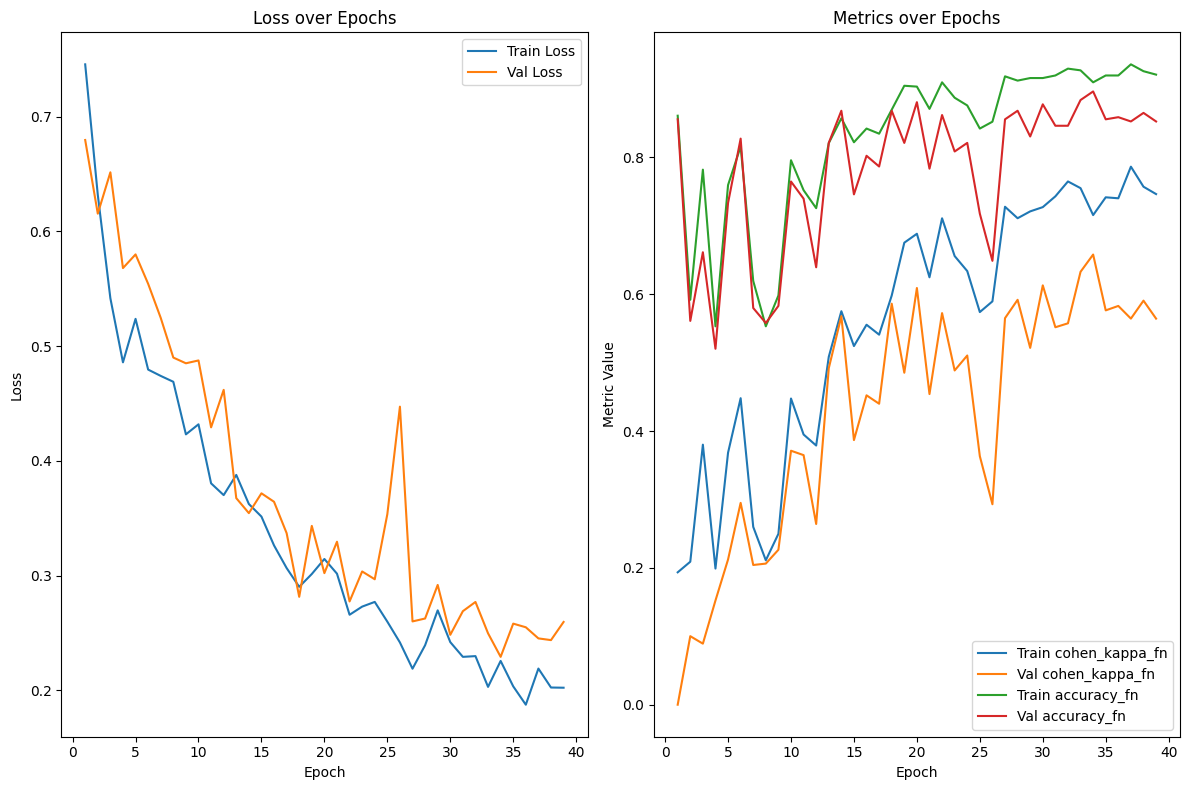

In [ ]:
trainer_cnn_3.plot_epochs()

In [ ]:
trainer_cnn_3.test(test_loader)

Test Loss: 0.2485 | Test cohen_kappa_fn: 0.6350 | Test accuracy_fn: 0.8771
